## Spark 2.0 made easy - Hands on Lab - USING LINUX DSVM
It should take about 11 minutes to run on a LDSVM DS4_v2 of  of 8 cores and 28GB RAM

![SparkAzure Logo](https://msdnshared.blob.core.windows.net/media/2016/08/Spark-Azure.png)

### Using LDSVM

## Go to the azure marketplace and click on the GET IT NOW button, and follow the steps.
https://azuremarketplace.microsoft.com/en-us/marketplace/apps/microsoft-ads.linux-data-science-vm-ubuntu?tab=Overview

A standalone instance of Apache Spark is preinstalled on the Linux DSVM to help you develop Spark applications locally first before testing and deploying on large clusters. You can run PySpark programs through the Jupyter kernel
![DSVM_image](https://msdnshared.blob.core.windows.net/media/2017/04/041817_0051_DeepLearnin1.png)

## Introduction to Spark


![About Spark](http://curriculum-release.s3-website-us-west-2.amazonaws.com/wiki-book/book_intro/spark_about.png)

Spark is a unified processing engine that can analyze big data using SQL, machine learning, graph processing or real time stream analysis:

![Spark Engines](http://curriculum-release.s3-website-us-west-2.amazonaws.com/wiki-book/book_intro/spark_4engines.png)

We will mostly focus on Spark SQL and DataFrames this evening.

Spark can read from many different databases and file systems and run in various environments:

![Spark Goal](http://curriculum-release.s3-website-us-west-2.amazonaws.com/wiki-book/book_intro/spark_goal.png)

Although Spark supports four languages (Scala, Java, Python, R), tonight we will use Python.
Broadly speaking, there are **2 APIs** for interacting with Spark:
- **DataFrames/SQL/Datasets:** general, higher level API for users of Spark
- **RDD:** a lower level API for spark internals and advanced programming

A Spark cluster is made of one Driver and many Executor JVMs (java virtual machines):

![Spark Physical Cluster, slots](http://curriculum-release.s3-website-us-west-2.amazonaws.com/wiki-book/book_intro/spark_cluster_slots.png)

The Driver sends Tasks to the empty slots on the Executors when work has to be done:

![Spark Physical Cluster, tasks](http://curriculum-release.s3-website-us-west-2.amazonaws.com/wiki-book/book_intro/spark_cluster_tasks.png)

On Azure Data Science VM, Spark is installed in local mode cluster, where the Driver and Executor code run in the same JVM. Local mode clusters are typically used for prototyping and learning Spark

Open the Apache Spark 2.0 related documentation in new tabs, so you can easily reference the API guide:

1) Spark 2.0.1  docs: https://spark.apache.org/docs/2.0.1/

2) DataFrame user documentation: https://spark.apache.org/docs/2.0.1/sql-programming-guide.html

3) PySpark API 2.0 docs: http://spark.apache.org/docs/latest/api/python/index.html

Other usefull links:

4) IPython magic commands: http://ipython.readthedocs.io/en/stable/interactive/magics.html

5) Guide for DataFrame Operations in PySpark: https://www.analyticsvidhya.com/blog/2016/10/spark-dataframe-and-operations/

6) Repo for Azure Machine Learning- Data Science: https://github.com/Azure/Azure-MachineLearning-DataScience

7) Understanding Resource Allocation configurations for Spark apps: http://site.clairvoyantsoft.com/understanding-resource-allocation-configurations-spark-application/


# Spark cluster configuration

#### (OPTIONAL STEP) IF RUNNING THIS NOTEBOOK IN AZURE DATA SCIENCE VM:
#### ssh into your machine
ssh username@ip<br>
sudo locate spark-defaults.conf<br>
sudo vi /dsvm/tools/spark/spark-2.0.2/conf/spark-defaults.conf<br>

#### then change the line below to fit your VM RAM (use 90% of the available RAM)
spark.driver.memory Xg

Let's make sure that we have our desired ram

In [1]:
sc._conf.get('spark.driver.memory')

u'25g'

### We need now to enable the SparkUI
Go to Your Azure portal, click on the Resource Group you just created (where the DSVM is) and click on the Network Security Group Resource and add and Inbound rule for the Spark UI port 4040. It should look like this:

Priotity: 1040, Name: SparkUI, Source: Any, Destination: Any, Service: Custom (Any/4040), Action: Allow


# Introduction to Car Rental Bookings

In [2]:
import pyspark

Let's read or source file - This files contains many columns related to one day of all the diferent car rental companies and their bookings

In [3]:
%%time
pricingDF = spark.read.csv("wasb://meetup-files@mdbdsmeetup.blob.core.windows.net/COMPETITOR_RATE_20170216.csv", header=False, inferSchema=True)

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 52.6 s


It took about ~50 seconds to read

Inferring the schema works for ad hoc analysis against smaller datasets. But when working on multi-TB+ data, it's better to provide an **explicit pre-defined schema manually**, so there's no inferring cost:

In [4]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, BooleanType, DoubleType

In [5]:
# Note that we are removing all space characters from the col names to prevent errors when writing to Parquet later

PricingSchema = StructType([StructField('UniqueIdentity', StringType(), True),
                     StructField('PickupLocationCode', StringType(), True),
                     StructField('ReturnLocationCode', StringType(), True),
                     StructField('CarClass', StringType(), True),
                     StructField('PickupDate', StringType(), True),       
                     StructField('ReturnDate', StringType(), True),       
                     StructField('PricingSegmentId', StringType(), True),       
                     StructField('ShopDate', StringType(), True),       
                     StructField('CompetitorId', StringType(), True),       
                     StructField('LengthOfRent', IntegerType(), True),       
                     StructField('PlanCode', StringType(), True),       
                     StructField('CurrencyCode', StringType(), True),                  
                     StructField('ShopSourceCode', StringType(), True),       
                     StructField('ShopVendorCode', StringType(), True),       
                     StructField('Rate', DoubleType(), True),       
                     StructField('TimeAndMileage', DoubleType(), True),       
                     StructField('EstimatedTotal', DoubleType(), True),       
                     StructField('LocationIndicator', StringType(), True),       
                     StructField('MileageAllowance', StringType(), True),                 
                     StructField('CreatedDate', StringType(), True),       
                     StructField('EndPickupDate', StringType(), True),       
                     StructField('PointOfSaleCountryCode', StringType(), True),       
                     StructField('CategoryCode', StringType(), True),       
                     StructField('RealTimeCanvasCode', StringType(), True)])

In [6]:
%%time
pricingDF = spark.read.csv("wasb://meetup-files@mdbdsmeetup.blob.core.windows.net/COMPETITOR_RATE_20170216.csv", header=False, schema=PricingSchema)

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 78.7 ms


In [7]:
pricingDF.columns

['UniqueIdentity',
 'PickupLocationCode',
 'ReturnLocationCode',
 'CarClass',
 'PickupDate',
 'ReturnDate',
 'PricingSegmentId',
 'ShopDate',
 'CompetitorId',
 'LengthOfRent',
 'PlanCode',
 'CurrencyCode',
 'ShopSourceCode',
 'ShopVendorCode',
 'Rate',
 'TimeAndMileage',
 'EstimatedTotal',
 'LocationIndicator',
 'MileageAllowance',
 'CreatedDate',
 'EndPickupDate',
 'PointOfSaleCountryCode',
 'CategoryCode',
 'RealTimeCanvasCode']

In [8]:
%%time
pricingDF.count()

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 30.2 s


25354815

Because we gave it the schema, it took less.

In [9]:
pricingDF.show(5)

+--------------+------------------+------------------+--------+-------------------+-------------------+----------------+-------------------+------------+------------+--------+------------+--------------+--------------+------+--------------+--------------+-----------------+----------------+-------------------+-------------------+----------------------+------------+------------------+
|UniqueIdentity|PickupLocationCode|ReturnLocationCode|CarClass|         PickupDate|         ReturnDate|PricingSegmentId|           ShopDate|CompetitorId|LengthOfRent|PlanCode|CurrencyCode|ShopSourceCode|ShopVendorCode|  Rate|TimeAndMileage|EstimatedTotal|LocationIndicator|MileageAllowance|        CreatedDate|      EndPickupDate|PointOfSaleCountryCode|CategoryCode|RealTimeCanvasCode|
+--------------+------------------+------------------+--------+-------------------+-------------------+----------------+-------------------+------------+------------+--------+------------+--------------+--------------+------+---

### ** Doing Date/Time Analysis**

Notice that the date or time columns are currently being interpreted as strings, rather than date or time objects:

In [10]:
pricingDF.printSchema()

root
 |-- UniqueIdentity: string (nullable = true)
 |-- PickupLocationCode: string (nullable = true)
 |-- ReturnLocationCode: string (nullable = true)
 |-- CarClass: string (nullable = true)
 |-- PickupDate: string (nullable = true)
 |-- ReturnDate: string (nullable = true)
 |-- PricingSegmentId: string (nullable = true)
 |-- ShopDate: string (nullable = true)
 |-- CompetitorId: string (nullable = true)
 |-- LengthOfRent: integer (nullable = true)
 |-- PlanCode: string (nullable = true)
 |-- CurrencyCode: string (nullable = true)
 |-- ShopSourceCode: string (nullable = true)
 |-- ShopVendorCode: string (nullable = true)
 |-- Rate: double (nullable = true)
 |-- TimeAndMileage: double (nullable = true)
 |-- EstimatedTotal: double (nullable = true)
 |-- LocationIndicator: string (nullable = true)
 |-- MileageAllowance: string (nullable = true)
 |-- CreatedDate: string (nullable = true)
 |-- EndPickupDate: string (nullable = true)
 |-- PointOfSaleCountryCode: string (nullable = true)
 |-- 

Let's use the unix_timestamp() function to convert the string into a timestamp:

https://people.apache.org/~pwendell/spark-nightly/spark-master-docs/latest/api/python/pyspark.sql.html?highlight=spark#pyspark.sql.functions.from_unixtime

In [11]:
from pyspark.sql.functions import *

In [12]:
# Note that PySpark uses the Java Simple Date Format patterns

from_pattern = 'MM/dd/yyyy hh:mm:ss'

pricingTsDF = pricingDF \
  .withColumn('PickupDateTS', unix_timestamp(pricingDF['PickupDate'], from_pattern).cast("timestamp")) \
  .drop('PickupDate') \
  .withColumn('ReturnDateTS', unix_timestamp(pricingDF['ReturnDate'], from_pattern).cast("timestamp")) \
  .drop('ReturnDate') \
  .withColumn('ShopDateTS', unix_timestamp(pricingDF['ShopDate'], from_pattern).cast("timestamp")) \
  .drop('ShopDate') \
  .withColumn('CreatedDateTS', unix_timestamp(pricingDF['CreatedDate'], from_pattern).cast("timestamp")) \
  .drop('CreatedDate') \
  .withColumn('EndPickupDateTS', unix_timestamp(pricingDF['EndPickupDate'], from_pattern).cast("timestamp")) \
  .drop('EndPickupDate') 

In [13]:
# new date type columns are moved to the end of the column order
pricingTsDF.printSchema()

root
 |-- UniqueIdentity: string (nullable = true)
 |-- PickupLocationCode: string (nullable = true)
 |-- ReturnLocationCode: string (nullable = true)
 |-- CarClass: string (nullable = true)
 |-- PricingSegmentId: string (nullable = true)
 |-- CompetitorId: string (nullable = true)
 |-- LengthOfRent: integer (nullable = true)
 |-- PlanCode: string (nullable = true)
 |-- CurrencyCode: string (nullable = true)
 |-- ShopSourceCode: string (nullable = true)
 |-- ShopVendorCode: string (nullable = true)
 |-- Rate: double (nullable = true)
 |-- TimeAndMileage: double (nullable = true)
 |-- EstimatedTotal: double (nullable = true)
 |-- LocationIndicator: string (nullable = true)
 |-- MileageAllowance: string (nullable = true)
 |-- PointOfSaleCountryCode: string (nullable = true)
 |-- CategoryCode: string (nullable = true)
 |-- RealTimeCanvasCode: string (nullable = true)
 |-- PickupDateTS: timestamp (nullable = true)
 |-- ReturnDateTS: timestamp (nullable = true)
 |-- ShopDateTS: timestamp (n

In [14]:
%%time
#now we can do things like this
pricingTsDF.select(month('CreatedDateTS')).distinct().orderBy('month(CreatedDateTS)').show()

+--------------------+
|month(CreatedDateTS)|
+--------------------+
|                   2|
|                   3|
+--------------------+

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 41.6 s


### ** Memory, Caching and write to Parquet**

Let's go to the SparkUI here: http://13.66.31.97:4040 (use your VM public IP) and understand what's happening inside the guts of Spark

In real use case scenario, an executor can hold multiple number of partitions depending on the memory configured for each executor. Generally a cluster of ‘n’ executors with each executor having ‘c’ computational threads (cores) should have n*c partitions. However  it should be noted that above way of calculating number of partitions may not fit well for all size of input data for a given size of cluster. Another way of getting optimal partitions count is by keeping each partition size between 50MB to 200MB. It is advised that a task should not take more than 5 seconds to complete. If average time of task completion exceeds more than 5 seconds then RDD should be repartitioned to decrease partitions size. It should also be kept in mind that RDD repartition will cause shuffle and hence will increase execution time.

By default 60% of memory allocated to spark application is used for RDD caching, 20% is used of data shuffle and rest 20% is used for storing objects created for task execution. It is highly recommended not to configure executor with more than 40G of  memory as higher memory allocation for executor can lead to large Garbage Collection (GC) pauses. 

In [15]:
pricingTsDF.rdd.getNumPartitions()

36

In [16]:
pricingTsDF.createOrReplaceTempView("pricingVIEW");

In [17]:
spark.catalog.cacheTable("pricingVIEW")

In [18]:
%%time
# Call .count() to materialize the cache
spark.table("pricingVIEW").count()

CPU times: user 12 ms, sys: 8 ms, total: 20 ms
Wall time: 1min 38s


25354815

In [19]:
# Note that the full scan + count in memory takes < 1 second!
pricingTsDF.count()

25354815

In [20]:
spark.sql("SHOW TABLES").show()

+-----------+-----------+
|  tableName|isTemporary|
+-----------+-----------+
|pricingview|       true|
+-----------+-----------+



Now let's see if we can improve times with repartitioning

In [21]:
pricingTsDF.repartition(18).createOrReplaceTempView("pricingVIEW2");

In [22]:
%%time
spark.catalog.cacheTable("pricingVIEW2")
spark.table("pricingVIEW2").count()

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 36.7 s


In [23]:
pricingTsDF2 = spark.table("pricingVIEW2")

Look at the partitions size in the STORAGE section of the Spark UI. They look now closer to 100MB each. This is a best practice.

Let's save now this partitions to a new parquet file

In [24]:
!ls

azureml
caffe2
CNTK
derby.log
DocumentDBSample.ipynb
h2o
IDEAR.ipynb
Introduction to Azure ML R notebooks.ipynb
Introduction to Microsoft R Operationalization.ipynb
IntroToJupyterPython.ipynb
IntroTutorialinMicrosoftR.ipynb
IntroTutorialinR.ipynb
IrisClassifierPyMLWebService.ipynb
julia
LoadDataIntoDW.ipynb
Meetup4-MDBDS-DSVM.ipynb
metastore_db
mxnet
Pricing
SparkML
SQLDW_Explorations.ipynb
tensorflow


In [25]:
%%time
pricingTsDF2.write.format('parquet').mode('overwrite').save("./Parquet/COMPETITOR_RATE_20170216.parquet")

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 25.7 s


Now the directory should contain 18 .gz compressed Parquet files (one for each partition):

In [26]:
!ls -l ./Parquet/COMPETITOR_RATE_20170216.parquet

total 555468
-rw-r--r-- 1 pablomarin pablomarin 31579869 Apr 21 19:19 part-r-00000-006261e2-400b-4743-bb26-dc3f14aca604.snappy.parquet
-rw-r--r-- 1 pablomarin pablomarin 31594877 Apr 21 19:19 part-r-00001-006261e2-400b-4743-bb26-dc3f14aca604.snappy.parquet
-rw-r--r-- 1 pablomarin pablomarin 31592691 Apr 21 19:19 part-r-00002-006261e2-400b-4743-bb26-dc3f14aca604.snappy.parquet
-rw-r--r-- 1 pablomarin pablomarin 31623386 Apr 21 19:19 part-r-00003-006261e2-400b-4743-bb26-dc3f14aca604.snappy.parquet
-rw-r--r-- 1 pablomarin pablomarin 31622641 Apr 21 19:19 part-r-00004-006261e2-400b-4743-bb26-dc3f14aca604.snappy.parquet
-rw-r--r-- 1 pablomarin pablomarin 31591826 Apr 21 19:19 part-r-00005-006261e2-400b-4743-bb26-dc3f14aca604.snappy.parquet
-rw-r--r-- 1 pablomarin pablomarin 31599357 Apr 21 19:19 part-r-00006-006261e2-400b-4743-bb26-dc3f14aca604.snappy.parquet
-rw-r--r-- 1 pablomarin pablomarin 31588931 Apr 21 19:19 part-r-00007-006261e2-400b-4743-bb26-dc3f14aca604.snappy.parquet
-rw-r--r-- 

Here's how you can easily read the parquet file from Azure Storage in the future:

In [27]:
tempDF = spark.read.parquet('./Parquet/COMPETITOR_RATE_20170216.parquet')

In [28]:
%%time
tempDF.count()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 229 ms


25354815

### **Analysis with PySpark DataFrames API**

#### ![Spark Operations](http://curriculum-release.s3-website-us-west-2.amazonaws.com/wiki-book/general/spark_ta.png)

DataFrames support two types of operations: *transformations* and *actions*.

Transformations, like `select()` or `filter()` create a new DataFrame from an existing one.

Actions, like `show()` or `count()`, return a value with results to the user. Other actions like `save()` write the DataFrame to distributed storage (like S3 or HDFS).

#### ![Spark T/A](http://curriculum-release.s3-website-us-west-2.amazonaws.com/wiki-book/pagecounts/trans_and_actions.png)

Transformations contribute to a query plan,  but  nothing is executed until an action is called.

Let's see how many nulls there are

In [29]:
%%time
pricingTsDF2.agg(*(sum(col(c).isNull().cast("integer")).alias(c) for c in pricingTsDF2.columns)).toJSON().take(1)

CPU times: user 32 ms, sys: 12 ms, total: 44 ms
Wall time: 4.73 s


[u'{"UniqueIdentity":0,"PickupLocationCode":0,"ReturnLocationCode":0,"CarClass":0,"PricingSegmentId":0,"CompetitorId":0,"LengthOfRent":0,"PlanCode":0,"CurrencyCode":61,"ShopSourceCode":0,"ShopVendorCode":0,"Rate":0,"TimeAndMileage":0,"EstimatedTotal":0,"LocationIndicator":18965186,"MileageAllowance":61,"PointOfSaleCountryCode":0,"CategoryCode":0,"RealTimeCanvasCode":0,"PickupDateTS":0,"ReturnDateTS":0,"ShopDateTS":0,"CreatedDateTS":0,"EndPickupDateTS":0}']

Lets start by checking how many unique values each column has

In [30]:
%%time
pricingTsDF2.agg(*(countDistinct(col(c)).alias(c) for c in pricingTsDF2.columns)).toJSON().take(1)

CPU times: user 64 ms, sys: 12 ms, total: 76 ms
Wall time: 5min 37s


[u'{"UniqueIdentity":25354815,"PickupLocationCode":1199,"ReturnLocationCode":1247,"CarClass":19,"PricingSegmentId":7,"CompetitorId":36,"LengthOfRent":63,"PlanCode":4,"CurrencyCode":6,"ShopSourceCode":19,"ShopVendorCode":4,"Rate":115820,"TimeAndMileage":194133,"EstimatedTotal":234170,"LocationIndicator":1,"MileageAllowance":47,"PointOfSaleCountryCode":17,"CategoryCode":13,"RealTimeCanvasCode":3,"PickupDateTS":3694,"ReturnDateTS":4077,"ShopDateTS":49785,"CreatedDateTS":25688,"EndPickupDateTS":3709}']

Let's see how many bookings there are per country

In [31]:
%%time
pricingTsDF2.select('PointOfSaleCountryCode').groupBy('PointOfSaleCountryCode').count().orderBy("count", ascending=False).show()

+----------------------+--------+
|PointOfSaleCountryCode|   count|
+----------------------+--------+
|                    US|23663084|
|                    CA|  759446|
|                    DE|   81070|
|                    GB|   79553|
|                    CH|   78891|
|                    FR|   77572|
|                    IT|   77463|
|                    UY|   77149|
|                    NL|   77117|
|                    SA|   74784|
|                    AR|   72125|
|                    AU|   59407|
|                    NO|   48703|
|                    AT|   36921|
|                    SG|   32145|
|                    CN|   29900|
|                    JP|   29485|
+----------------------+--------+

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 1.03 s


Let's see how many bookings are made where Pickup is different than return location

In [32]:
pricingTsDF2.filter(pricingTsDF2.PickupLocationCode <> pricingTsDF2.ReturnLocationCode).groupBy("PickupLocationCode", "PointOfSaleCountryCode").count().orderBy("count", ascending=False).show()

+------------------+----------------------+------+
|PickupLocationCode|PointOfSaleCountryCode| count|
+------------------+----------------------+------+
|               LAX|                    US|159999|
|               BOS|                    US|123375|
|               ATL|                    US|121420|
|               MCO|                    US|106321|
|               DCA|                    US|100808|
|               SFO|                    US| 90005|
|               IAD|                    US| 81717|
|               LAS|                    US| 77067|
|               BWI|                    US| 75265|
|               TPA|                    US| 73799|
|               MIA|                    US| 71903|
|               PHL|                    US| 70824|
|               DEN|                    US| 70087|
|               ORD|                    US| 68302|
|               EWR|                    US| 67989|
|               SAN|                    US| 65464|
|               SNA|           

## **SQL Queries and Plotting**

Now let's explore the data a bit more, but this time using SQL.

In [33]:
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.pyplot import *

Let's plot the rate changes during a day for L car class in the major city Los Angeles (LAX) where pickup = return and the lenght of rental was 3 days and pricing segment is "ROD" with Category "S"

In [34]:
pandas_df = spark.sql("""
SELECT CompetitorId, CarClass, Rate/100 as Rate, LengthOfRent, PricingSegmentId, CreatedDateTS \
            FROM pricingview2 \
            WHERE PickupLocationCode ==  ReturnLocationCode and PickupLocationCode == 'LAX' \
            and CarClass in ('L') \
            and LengthOfRent == 3 \
            and PricingSegmentId in ('ROD') and CategoryCode == 'S' \
            SORT BY CreatedDateTS
        """).toPandas()

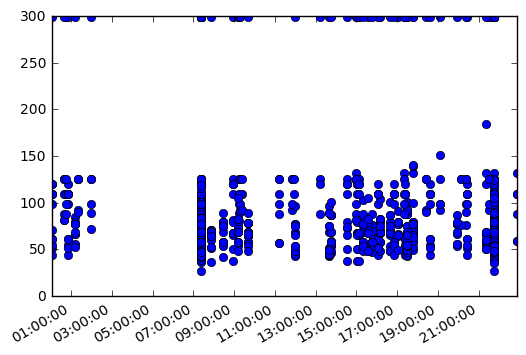

In [35]:
%matplotlib inline
plot_date(pandas_df.CreatedDateTS, pandas_df.Rate)
plt.gcf().autofmt_xdate()
plt.show()

Now let's see the average price of each Competitor during this day, for rentals in LAX, 3 days, M Class, ROD Price Segment and S Category Code

In [36]:
pandas_df = spark.sql("""
SELECT CompetitorId, avg(Rate)/100 as Rate\
            FROM pricingview2 \
            WHERE PickupLocationCode ==  ReturnLocationCode and PickupLocationCode == 'LAX' \
            and CarClass in ('M') \
            and LengthOfRent == 3 \
            and PricingSegmentId in ('ROD') and CategoryCode == 'S' \
            group by CompetitorId
        """).toPandas()

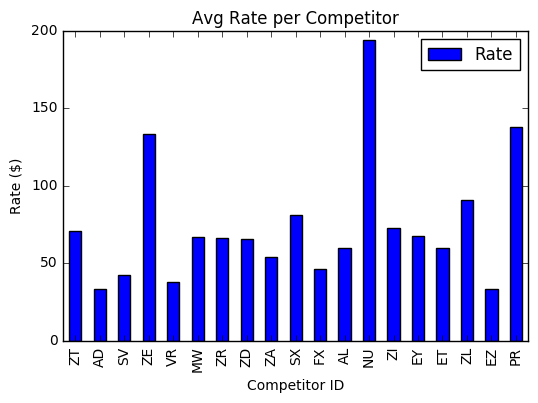

In [37]:
%matplotlib inline
# HISTOGRAM OF TIP AMOUNTS AND PASSENGER COUNT
ax1 = pandas_df[['Rate']].plot(kind='bar')
ax1.set_xticklabels(pandas_df.CompetitorId)
ax1.set_title('Avg Rate per Competitor')
ax1.set_xlabel('Competitor ID')
ax1.set_ylabel('Rate ($)')
plt.suptitle('')
plt.show()

## You made it to the end of the lab Part 1.
## Next lab we will take this data set and start predicting 